In [1]:
import numpy as np
import pandas as pd
import toad
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from toad.plot import bin_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

In [2]:
parse_dates = ['CreatedDate', 'RequestedDate', 'AccTime', 'PupTime', 'DelTime']
data = pd.read_csv('Booking_Dispatch_training_set.csv', parse_dates = parse_dates, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
parse_dates2 = ['CreatedDate', 'RequestedDate']

validation = pd.read_csv('Booking_Dispatch_validation_set.csv', parse_dates = parse_dates2, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))

In [4]:
data.shape
# (3000000, 37)

(3000000, 37)

In [5]:
validation.shape

(300000, 17)

In [6]:
data['TargetVariable'].value_counts()/len(data)

Completed    0.776306
Cancelled    0.128554
No Job       0.082690
ELSE         0.012449
Name: TargetVariable, dtype: float64

In [7]:
# binary target: 'Cancelled'
target_dict = {'Cancelled':1,'Completed':0,'ELSE':0,'No Job':0,}
data['target_2cls_Cancelled'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Cancelled'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'Completed'
target_dict = {'Cancelled':0,'Completed':1,'ELSE':0,'No Job':0,}
data['target_2cls_Completed'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Completed'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'ELSE'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':1,'No Job':0,}
data['target_2cls_ELSE'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_ELSE'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'No Job'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':0,'No Job':1,}
data['target_2cls_NoJob'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_NoJob'] = validation['TargetVariable'].replace(target_dict)

In [8]:
# 4分类target
target_dict2 = {
    'Cancelled':0,
    'Completed':1,
    'No Job':2,
    'ELSE':3,
}

data['target_4cls'] = data['TargetVariable'].replace(target_dict2)
validation['target_4cls'] = validation['TargetVariable'].replace(target_dict2)

In [9]:
validation.columns

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'FinalDispatchStatus', 'TargetVariable',
       'target_2cls_Cancelled', 'target_2cls_Completed', 'target_2cls_ELSE',
       'target_2cls_NoJob', 'target_4cls'],
      dtype='object')

In [10]:
# 可以入模的 features + target ; 即排除
cols = ['BookingID', 'BookingSource', 'Conditions', 'HasCondition', 'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet'
        , 'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb', 'PuLat', 'PuLong', 'TargetVariable','target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob','target_4cls']
data = data[cols]
validation=validation[cols]

# 2. Feature Engineering

## 2.1 Suburb

<AxesSubplot:xlabel='PuSuburb', ylabel='prop'>

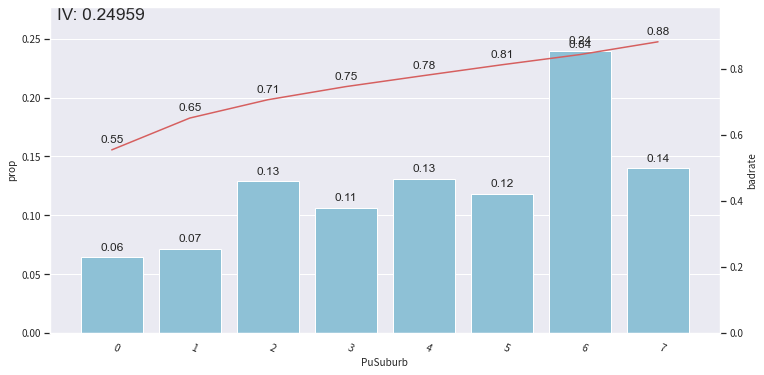

In [11]:
c = toad.transform.Combiner()
col = 'PuSuburb'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05) # DT, Kmeans, Quantile, Step 
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

<AxesSubplot:xlabel='PuSuburb', ylabel='prop'>

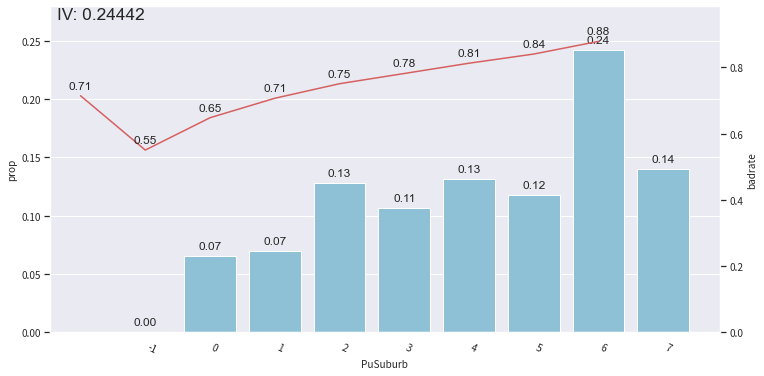

In [12]:
# 在validation上测试
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed') 

# 由于-1的关系，有一个位移，忽视掉
#结论：train的IV0.2495，test时0.2444，稳定性非常好且iv很高；分箱的梯度非常明显

In [13]:
c.export()

{'PuSuburb': [['Bathurst',
   'Lithgow',
   'Brownlow Hill',
   'South Maroota',
   'Pitt Town',
   'Clarendon',
   'Lansdowne',
   'Windsor',
   'Hobartville',
   'Wollongong',
   'Bowenfels',
   'Glenmore',
   'South Windsor',
   'Audley',
   'Douglas Park',
   'Warrimoo',
   'Balmoral (South)',
   'Gosford',
   'Scotland Island',
   'Ku-Ring-Gai Chase',
   'Ebenezer',
   'Londonderry',
   'Cottage Point',
   'Wilton',
   'Oakdale',
   'Berkshire Park',
   'Cattai',
   'Palm Beach',
   'Whale Beach',
   'Springwood',
   'Oakville',
   'Mulgrave',
   'Mcgraths Hill',
   'Shanes Park',
   'The Oaks',
   'Port Kembla',
   'REGENTS PARK',
   'Sun Valley',
   'Werombi',
   'Lakesland',
   'Kelso',
   'Hill Top (North)',
   'HAYMARKET',
   'Belimbla Park',
   'Kurmond',
   'Vineyard',
   'Bligh Park',
   'Mount Vernon',
   'Agnes Banks',
   'Winmalee',
   'Windsor Downs',
   'Castlereagh',
   'Shalvey',
   'Bringelly',
   'WEST HOXTON',
   'Bilgola Beach',
   'Thirroul',
   'Wallerawang',


In [14]:
def PuSuburbBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'PuSuburb'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05) 
        data['PuSuburbBins_'+val] = c.transform(data[['PuSuburb']], labels=False) # 纯分箱不做woe转化
        data_test['PuSuburbBins_'+val] = c.transform(data_test[['PuSuburb']], labels=False)
    return data, data_test

data, validation = PuSuburbBins(data, validation)


In [15]:
data[['PuSuburbBins_Cancelled','PuSuburbBins_Completed','PuSuburbBins_ELSE','PuSuburbBins_NoJob']].head()

,PuSuburbBins_Cancelled,PuSuburbBins_Completed,PuSuburbBins_ELSE,PuSuburbBins_NoJob
0,0,6,0,3
1,4,3,1,3
2,2,5,0,2
3,2,5,0,3
4,6,0,1,6


In [16]:
toad.quality(data[['PuSuburbBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
PuSuburbBins_Cancelled,0.249979,0.217016,0.369365,7.0


In [17]:
toad.quality(data[['PuSuburbBins_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
PuSuburbBins_Completed,0.249585,0.331691,0.509915,8.0


In [18]:
toad.quality(data[['PuSuburbBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
PuSuburbBins_ELSE,0.216695,0.02451,0.065578,2.0


In [19]:
toad.quality(data[['PuSuburbBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
PuSuburbBins_NoJob,0.227563,0.149151,0.276917,8.0


In [20]:
#每个target的IV都很高，因此每个衍生变量都有效

## 2.2 Pickup lattitude & longitude

In [21]:
knn = KNeighborsClassifier(n_neighbors = 101)

knn.fit(data[['PuLat','PuLong']],data['target_2cls_Completed'])

data['KNN_temp'] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]

<AxesSubplot:xlabel='KNN_temp', ylabel='prop'>

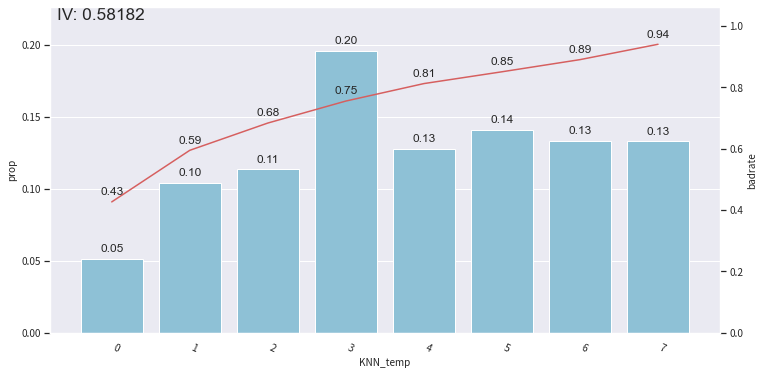

In [22]:
c = toad.transform.Combiner()
col = 'KNN_temp'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


<AxesSubplot:xlabel='KNN_temp', ylabel='prop'>

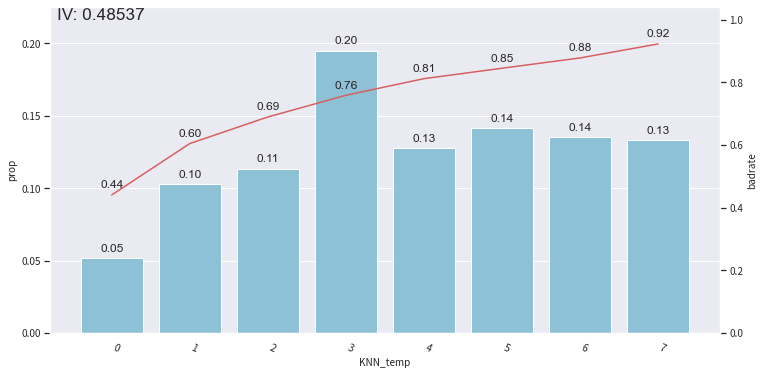

In [23]:
validation['KNN_temp'] = knn.predict_proba(validation[['PuLat','PuLong']])[:,1]
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [24]:
c.export()

{'KNN_temp': [0.5346534653465347,
  0.6534653465346535,
  0.7227722772277227,
  0.801980198019802,
  0.8415841584158416,
  0.8811881188118812,
  0.9207920792079208]}

In [25]:
def PuLatLongKNN(data, test):
    data = data.copy()
    test = test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        knn = KNeighborsClassifier(n_neighbors = 101)
        knn.fit(data[['PuLat','PuLong']],data[target])
        data['PuLatLongKNN_'+val] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]
        test['PuLatLongKNN_'+val] = knn.predict_proba(test[['PuLat','PuLong']])[:,1]
    return data, test 

data,validation = PuLatLongKNN(data,validation)

In [26]:
toad.quality(data[['PuLatLongKNN_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
PuLatLongKNN_Cancelled,0.709143,0.212199,0.383407,91.0


In [27]:
toad.quality(data[['PuLatLongKNN_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
PuLatLongKNN_Completed,0.590384,0.324179,0.531429,99.0


In [28]:
toad.quality(data[['PuLatLongKNN_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
PuLatLongKNN_ELSE,1.826409,0.024466,0.066926,35.0


In [29]:
toad.quality(data[['PuLatLongKNN_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
PuLatLongKNN_NoJob,0.761531,0.145988,0.285154,58.0


## 2.3 Time

In [30]:
def OrderHour(data):
    data = data.copy()
    data['OrderHour'] = data['RequestedDate'].apply(lambda x: x.hour).astype(int)
    return data 
data = OrderHour(data)
validation= OrderHour(validation)

<AxesSubplot:xlabel='OrderHour', ylabel='prop'>

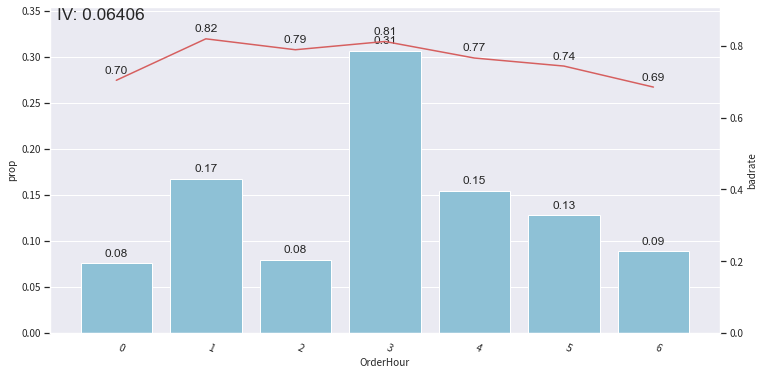

In [31]:
c = toad.transform.Combiner()
col = 'OrderHour'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [32]:
def DayOfWeek(data):
    data = data.copy()
    data['DayOfWeek'] = data['RequestedDate'].apply(lambda x: x.weekday()+1)
    return data
data = DayOfWeek(data)
validation = DayOfWeek(validation)

<AxesSubplot:xlabel='DayOfWeek', ylabel='prop'>

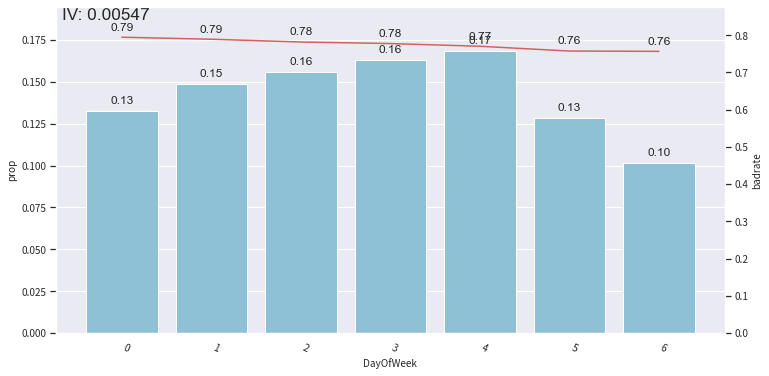

In [33]:
c = toad.transform.Combiner()
col = 'DayOfWeek'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [34]:
dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_Completed'])

def OrderTimeDT(data):
    data = data.copy()
    data['OrderTimeDT'] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
    return data 

In [35]:
data = OrderTimeDT(data)
validation = OrderTimeDT(validation)

<AxesSubplot:xlabel='OrderTimeDT', ylabel='prop'>

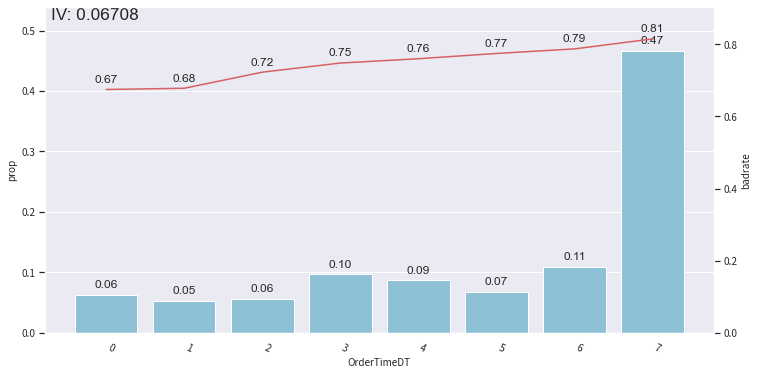

In [36]:
c = toad.transform.Combiner()
col = 'OrderTimeDT'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [37]:
def OrderTimeDT(data, test):
    data = data.copy()
    test = test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
        dt.fit(data[['DayOfWeek','OrderHour']] , data[target])
        data['OrderTimeDT_'+val] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
        test['OrderTimeDT_'+val] = dt.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
    return data, test 

data,validation = OrderTimeDT(data,validation)

In [38]:
toad.quality(data[['OrderTimeDT_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
OrderTimeDT_Completed,0.067079,0.343049,0.52564,8.0


In [39]:
toad.quality(data[['OrderTimeDT_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
OrderTimeDT_Cancelled,0.039493,0.223038,0.381403,8.0


In [40]:
toad.quality(data[['OrderTimeDT_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
OrderTimeDT_ELSE,0.020355,0.024582,0.06685,9.0


In [41]:
toad.quality(data[['OrderTimeDT_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
OrderTimeDT_NoJob,0.100457,0.150465,0.281428,7.0


## 2.4 Conditions

<AxesSubplot:xlabel='Conditions', ylabel='prop'>

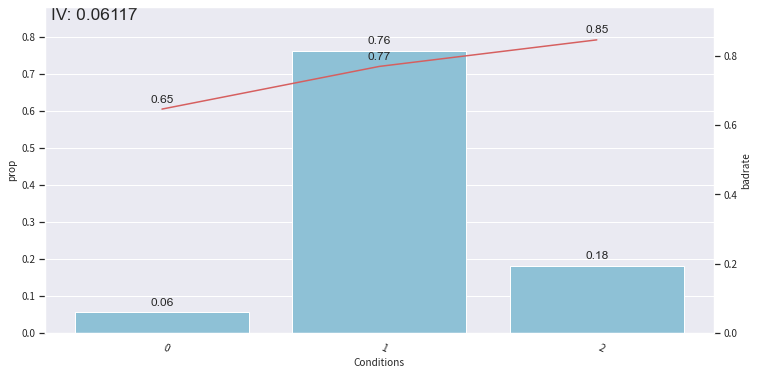

In [42]:
data['Conditions'] = data['Conditions'].astype(str) # condition 属于 cateogorical fearture, 本身是numerical所以会被认为是continous feature
validation['Conditions'] = validation['Conditions'].astype(str)
c = toad.transform.Combiner()
col = 'Conditions'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

In [43]:
def ConditionsBins(data, test):
    data = data.copy()
    test = test.copy()
    data['Conditions'] = data['Conditions'].astype(str)
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'Conditions'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05)
        data['ConditionsBins_'+val] = c.transform(data[['Conditions']], labels=False)
        test['ConditionsBins_'+val] = c.transform(test[['Conditions']], labels=False)
    return data, test

data, validation = ConditionsBins(data, validation)

In [44]:
toad.quality(data[['ConditionsBins_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
ConditionsBins_Completed,0.061174,0.343603,0.526263,3.0


In [45]:
toad.quality(data[['ConditionsBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
ConditionsBins_Cancelled,0.041767,0.222731,0.381125,2.0


In [46]:
toad.quality(data[['ConditionsBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
ConditionsBins_ELSE,0.346219,0.024435,0.064631,2.0


In [47]:
toad.quality(data[['ConditionsBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
ConditionsBins_NoJob,0.23399,0.150224,0.278627,4.0


## 2.5 Booking Fleet = Dispatch Fleet

In [48]:
equal = list()
for i in range(data.shape[0]):
    if data['BookingFleet'][i] == data['DispatchFleet'][i]:
        equal.append('True')
    else:
        equal.append('False')
#check whether booking fleet is the same as dispatch feet and create a new variable

In [49]:
equal2 = list()
for i in range(validation.shape[0]):
    if validation['BookingFleet'][i] == validation['DispatchFleet'][i]:
        equal2.append('True')
    else:
        equal2.append('False')

In [50]:
data['BookingisDispatch'] = equal
validation['BookingisDispatch'] = equal2

## 2.6 Dispatch Fleet

<AxesSubplot:xlabel='DispatchFleet', ylabel='prop'>

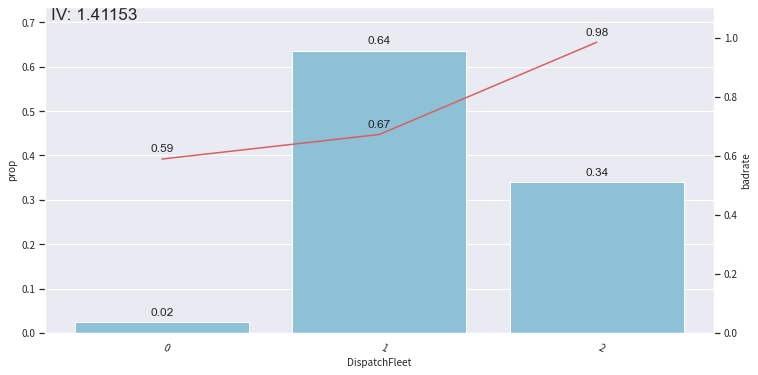

In [51]:
c = toad.transform.Combiner()
col = 'DispatchFleet'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.01)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


<AxesSubplot:xlabel='DispatchFleet', ylabel='prop'>

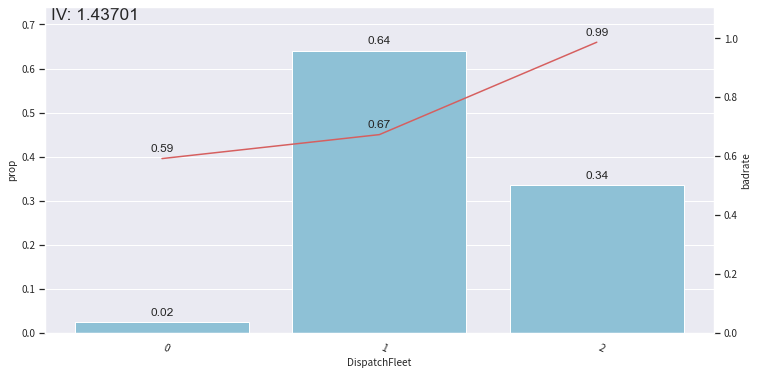

In [52]:
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

In [53]:
c.export()

{'DispatchFleet': [['Training Sydney',
   'South Western Cabs',
   'iHail',
   'Sydney Tiger Team',
   '13cabs Wollongong',
   'WATs Sydney',
   'Blue Mountains 13cabs'],
  ['13cabs Sydney', 'Test Sydney'],
  ['Silver Service Sydney']]}

In [54]:
def DispatchFleetBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'DispatchFleet'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.01) 
        data['DispatchFleetBins_'+val] = c.transform(data[['DispatchFleet']], labels=False) 
        data_test['DispatchFleetBins_'+val] = c.transform(data_test[['DispatchFleet']], labels=False)
    return data, data_test

data,validation = DispatchFleetBins(data,validation)


In [55]:
toad.quality(data[['DispatchFleetBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
DispatchFleetBins_Cancelled,1.411809,0.208251,0.334045,3.0


In [56]:
toad.quality(data[['DispatchFleetBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
DispatchFleetBins_ELSE,1.077869,0.024048,0.060731,3.0


In [57]:
toad.quality(data[['DispatchFleetBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
DispatchFleetBins_NoJob,0.957894,0.145694,0.258893,3.0


## 2.7 Booking Fleet

In [58]:
#booking fleet 还需要讨论
#before_booking=data.to_csv('mid.csv')

In [68]:
#before_booking_val=validation.to_csv('midval.csv')

In [2]:
data=pd.read_csv('mid.csv')

In [3]:
validation=pd.read_csv('midval.csv')

In [4]:
data = data.iloc[:,1:]

In [5]:
validation = validation.iloc[:,1:]

In [8]:
data[['BookingFleet','target_2cls_Completed']].groupby('BookingFleet').agg(['mean','count']).\
sort_values(by=('target_2cls_Completed','mean'),ascending=True)

target_2cls_Completed         
                                       mean    count
BookingFleet                                        
Training Sydney                    0.002483     2416
iHail                              0.394737      304
Sydney Tiger Team                  0.466667       15
Blue Mountains 13cabs              0.654786    21352
Test Sydney                        0.708333       96
South Western Cabs                 0.719902      814
13cabs Sydney                      0.772805  2766068
WATs Sydney                        0.832917   118037
Silver Service Sydney              0.860334    90881
13cabs Wollongong                  0.941176       17

<AxesSubplot:xlabel='BookingFleet', ylabel='prop'>

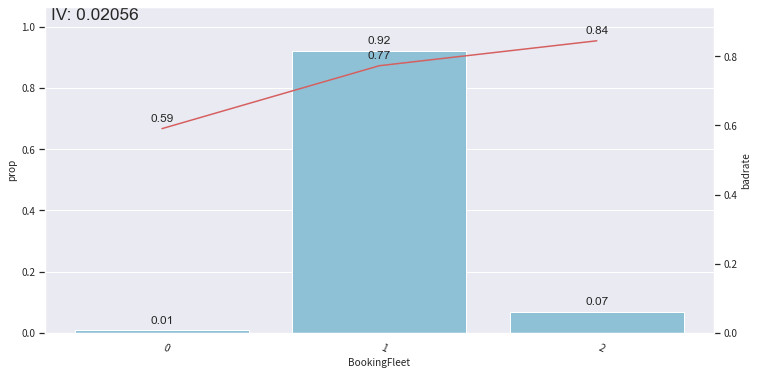

In [9]:
c = toad.transform.Combiner()
col = 'BookingFleet'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.001)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


<AxesSubplot:xlabel='BookingFleet', ylabel='prop'>

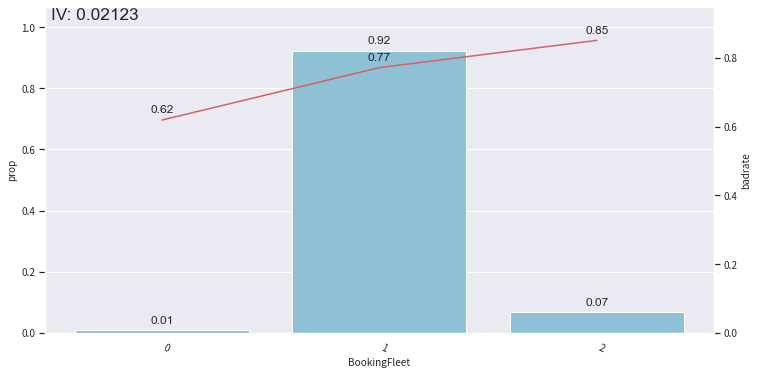

In [10]:
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

In [11]:
def BookingFleetBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'BookingFleet'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.001) 
        data['BookingFleetBins_'+val] = c.transform(data[['BookingFleet']], labels=False) 
        data_test['BookingFleetBins_'+val] = c.transform(data_test[['BookingFleet']], labels=False)
    return data, data_test

data,validation = BookingFleetBins(data,validation)


In [12]:
toad.quality(data[['BookingFleetBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
BookingFleetBins_Cancelled,0.033075,0.223436,0.382003,4.0


In [13]:
toad.quality(data[['BookingFleetBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
BookingFleetBins_ELSE,0.254508,0.024455,0.065169,2.0


In [14]:
toad.quality(data[['DispatchFleetBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
DispatchFleetBins_NoJob,0.957894,0.145694,0.258893,3.0


In [ ]:
#data = data.drop(columns=['BookingID', 'Conditions','CreatedDate', 'RequestedDate',
#                         'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb','PuLat', 
#                          'PuLong', 'TargetVariable','KNN_temp','OrderTimeDT',]

In [ ]:
#validation = validation.drop(columns=['BookingID', 'Conditions','CreatedDate', 'RequestedDate',
#                         'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb','PuLat', 
#                          'PuLong', 'TargetVariable','KNN_temp','OrderTimeDT',]

## 2.6 Booking Source

<AxesSubplot:xlabel='BookingSource', ylabel='prop'>

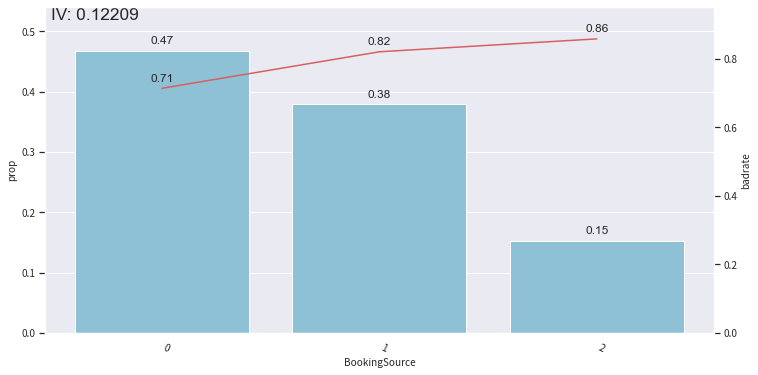

In [15]:
c = toad.transform.Combiner()
col = 'BookingSource'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


<AxesSubplot:xlabel='BookingSource', ylabel='prop'>

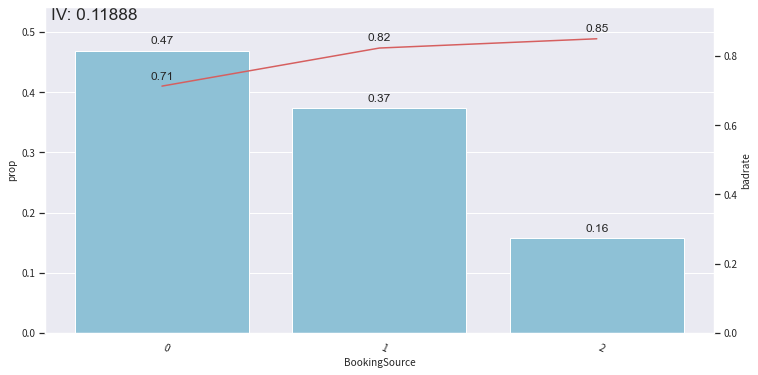

In [16]:
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed') 


In [17]:
def BookingSourceBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'BookingSource'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05) 
        data['BookingSourceBins_'+val] = c.transform(data[['BookingSource']], labels=False) 
        data_test['BookingSourceBins_'+val] = c.transform(data_test[['BookingSource']], labels=False)
    return data, data_test

data,validation = BookingSourceBins(data,validation)


In [18]:
data[['BookingSourceBins_Cancelled','BookingSourceBins_Completed','BookingSourceBins_ELSE','BookingSourceBins_NoJob']].head()

,BookingSourceBins_Cancelled,BookingSourceBins_Completed,BookingSourceBins_ELSE,BookingSourceBins_NoJob
0,1,1,2,1
1,1,1,2,1
2,2,0,1,0
3,0,2,0,2
4,2,0,1,0


In [19]:
toad.quality(data[['BookingSourceBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
BookingSourceBins_Cancelled,0.460776,0.213501,0.359142,3.0


In [20]:
toad.quality(data[['BookingSourceBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
BookingSourceBins_ELSE,0.765604,0.024374,0.062619,3.0


In [21]:
toad.quality(data[['BookingSourceBins_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
BookingSourceBins_Completed,0.122085,0.340135,0.521081,3.0


In [22]:
toad.quality(data[['BookingSourceBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
BookingSourceBins_NoJob,0.009098,0.1516,0.284946,3.0


## 2.7 Create dummy variables

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 54 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   BookingID                    int64  
 1   BookingSource                object 
 2   Conditions                   int64  
 3   HasCondition                 int64  
 4   IsAccountBooking             int64  
 5   CreatedDate                  object 
 6   RequestedDate                object 
 7   BookingFleet                 object 
 8   DispatchFleet                object 
 9   AreaNumber                   int64  
 10  PuPlace                      object 
 11  PuAddress                    object 
 12  PuSuburb                     object 
 13  PuLat                        float64
 14  PuLong                       float64
 15  TargetVariable               object 
 16  target_2cls_Cancelled        int64  
 17  target_2cls_Completed        int64  
 18  target_2cls_ELSE             int64  
 19  

In [27]:
data['HasCondition']=np.where(data['HasCondition'] == 'Yes',1,0)

In [30]:
validation['HasCondition']=np.where(validation['HasCondition'] == 'Yes',1,0)

In [34]:
data['IsAccountBooking']=np.where(data['IsAccountBooking'] == 'Yes',1,0)
validation['IsAccountBooking']=np.where(validation['IsAccountBooking'] == 'Yes',1,0)

In [38]:
data['BookingisDispatch']=np.where(data['BookingisDispatch'] == True,1,0)
validation['BookingisDispatch']=np.where(validation['BookingisDispatch'] == True,1,0)

In [41]:
final=data.to_csv('final.csv')

In [42]:
final_val=validation.to_csv('final_val.csv')

# 3. Model

In [43]:
train = pd.read_csv('final.csv')

In [44]:
validation = pd.read_csv('final_val.csv')

In [45]:
train = train.iloc[:,1:]

In [46]:
validation = validation.iloc[:,1:]

In [49]:
train.columns

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'TargetVariable', 'target_2cls_Cancelled',
       'target_2cls_Completed', 'target_2cls_ELSE', 'target_2cls_NoJob',
       'target_4cls', 'PuSuburbBins_Cancelled', 'PuSuburbBins_Completed',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob', 'KNN_temp',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 'OrderTimeDT',
       'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed', 'OrderTimeDT_ELSE',
       'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Cancelled', 'DispatchFleetBins_Completed',
       'DispatchFleetBins_ELSE', 'DispatchFl

In [50]:
mdl_cols = ['HasCondition','IsAccountBooking',  'PuSuburbBins_Cancelled', 'PuSuburbBins_Completed',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob','PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 
       'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed', 'OrderTimeDT_ELSE',
       'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Cancelled', 'DispatchFleetBins_Completed',
       'DispatchFleetBins_ELSE', 'DispatchFleetBins_NoJob',
       'BookingFleetBins_Cancelled', 'BookingFleetBins_Completed',
       'BookingFleetBins_ELSE', 'BookingFleetBins_NoJob',
       'BookingSourceBins_Cancelled', 'BookingSourceBins_Completed',
       'BookingSourceBins_ELSE', 'BookingSourceBins_NoJob']

## 3.1 Logistic Regression

In [55]:
#iteration少了会跑不出来
logit = LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs',max_iter=10000)
logit.fit(train[mdl_cols],train['target_4cls'])


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [56]:
logit.predict_proba(validation[mdl_cols])

array([[5.28482996e-02, 7.94263367e-01, 1.50833827e-01, 2.05450674e-03],
       [1.79960483e-01, 7.62046921e-01, 5.42583690e-02, 3.73422712e-03],
       [8.29085807e-05, 9.99717246e-01, 1.94459488e-04, 5.38635234e-06],
       ...,
       [6.60516910e-02, 8.62477132e-01, 6.75843423e-02, 3.88683524e-03],
       [5.34502885e-05, 9.99761188e-01, 1.80767377e-04, 4.59415042e-06],
       [4.25016624e-01, 3.89610332e-01, 8.95877115e-02, 9.57853324e-02]])

In [57]:
print('Training accuracy: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_4cls']))
print('validation accuracy: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(logit.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('validation f1_score: ', f1_score(logit.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.796623
validation accuracy:  0.7964966666666666
Training f1_score:  0.3780155240372233
validation f1_score:  0.37169026265638155


In [58]:
#对于complete的准确率较高，其他很低
print('Training accuracy of cancelled: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_Cancelled']))
print('Training accuracy of completed: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_Completed']))
print('Training accuracy of ELSE: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_ELSE']))
print('Training accuracy of No Job: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_NoJob']))

Training accuracy of cancelled:  0.11667933333333333
Training accuracy of completed:  0.7991076666666667
Training accuracy of ELSE:  0.06815833333333333
Training accuracy of No Job:  0.12262


In [59]:
logit_proba = pd.DataFrame(data = logit.predict_proba(validation[mdl_cols]), columns = ['Cancelled','Completed','ELSE','NoJob'])
logit_proba.corr()

# 输入4个预测概率之间的 Pearson correlation，看之间的概率是否有相关性；
# completed和cancelled有明显的负相关，和else也是，Nojob较低

,Cancelled,Completed,ELSE,NoJob
Cancelled,1.000000,-0.891778,0.293560,0.152185
Completed,-0.891778,1.000000,-0.665105,-0.321358
ELSE,0.293560,-0.665105,1.000000,0.099803
NoJob,0.152185,-0.321358,0.099803,1.000000


In [ ]:
#可以不用跑
logit = LogisticRegression(multi_class = 'ovr') # 'one_vs_rest'
logit.fit(train[mdl_cols],train['target_4cls'])

In [ ]:
print('Training accuracy: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(logit.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(logit.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))


## 3.2 Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#跑不出来，可以试着跑下
rf = RandomForestClassifier()
cls = GridSearchCV(rf, {'n_estimators' : [50,200,500], 'max_depth' : [2,3]},cv=3) # min_samples_weight =0.05

In [ ]:
#同上
n = np.argmax(cls.cv_results_['mean_test_score'])
print(cls.cv_results_['params'][n])

rf = cls.best_estimator_ #保存最优的模型

In [61]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2) # min_samples_split

rf.fit(train[mdl_cols],train['target_4cls'])

RandomForestClassifier(max_depth=2, n_estimators=500)

In [62]:
print('Training accuracy: ', accuracy_score(rf.predict(train[mdl_cols]), train['target_4cls']))
print('validation accuracy: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(rf.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('validation f1_score: ', f1_score(rf.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.7763063333333333
validation accuracy:  0.7755833333333333
Training f1_score:  0.21851702005603763
validation f1_score:  0.21840240296616134


## 3.3 XGBoost

In [63]:
xgb = xgboost.XGBClassifier(n_estimators = 500, max_depth = 2, min_samples_weight = 0.05)
xgb.fit(train[mdl_cols],train['target_4cls']) 

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:07:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_samples_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_samples_weight=0.05, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
print('Training accuracy: ', accuracy_score(xgb.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(xgb.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(xgb.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.8010453333333334
Test accuracy:  0.8000166666666667
Training f1_score:  0.38269267605660573
Test f1_score:  0.37475828694234703


## 3.4 Naive Bayes

In [65]:
gnb = GaussianNB()
gnb.fit(train[mdl_cols], train['target_4cls'])

GaussianNB()

In [66]:
print('Training accuracy: ', accuracy_score(gnb.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(gnb.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(gnb.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(gnb.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.46772633333333336
Test accuracy:  0.46317
Training f1_score:  0.3387349518060806
Test f1_score:  0.3353384243400674


In [ ]:
#xgboost的accuracy最高 f1和logistic差不多